In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage

import pickle

In [2]:
## Importing the dataset
df = pd.read_csv('data_for_CS.csv',  encoding='latin-1')

## Understanding the data.

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [6]:
### No. of unique values in each column
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [7]:
## No. is null vales in each column
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Data Cleaning.

#### Seems we have lot of rows where customerID is missing. Lets see the percentage of missing data.

In [8]:
## Function to print no. of missing value and there percentage for columns that have missing values.
def missing_values_summary(df):
    total_rows = df.shape[0]
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / total_rows) * 100
    missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
    missing_summary = missing_summary[(missing_summary['Missing Values'] != 0)]
    cols_values_missing = missing_summary.shape[0]
    print(f'{cols_values_missing} columns have missing values')
    return missing_summary

In [9]:
missing_values_summary(df)

2 columns have missing values


,Missing Values,Percentage
Description,1454,0.268311
CustomerID,135080,24.926694


In [10]:
## It's not possible to fill the customerID, so we will simply drop the missing data.
df_clean = df.dropna(subset=['Description', 'CustomerID'])

In [11]:
df_clean.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
### checking for no. of duplicate rows
df_clean.duplicated().sum()

5225

In [13]:
## droping duplicates
df_clean.drop_duplicates(inplace= True)

## Data preprocessing.

In [14]:
### Lets see the datatype of columns.
df_clean.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

#### InvoiceNo is supposed to be INT but it's object and InvoiceDate needs to be changed to DateTime. And the Stock Code need a further Investigation as it's datatype is object instead of INT.

In [15]:
#### Lets check if the InvoiceNo constains any alphabet
df_clean['InvoiceNo'] = df_clean['InvoiceNo'].astype(str)
alphabetic_chars = df_clean['InvoiceNo'].str.extract(r'([a-zA-Z]+)', expand=False)
unique_chars = alphabetic_chars.dropna().unique()
print("Unique alphabetic characters:", unique_chars)

Unique alphabetic characters: ['C']


In [16]:
## this list contains all the orders that were Cancelled.
can_order = df_clean[df_clean['InvoiceNo'].str.contains(r'[C]')]
print('Total cancelled orders are:', can_order.shape[0])
can_order.head()

Total cancelled orders are: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [17]:
### All the cancelled orders have negative quantity, lets check the relation
(df_clean[df_clean['Quantity'] < 0 & df_clean['InvoiceNo'].astype(str).str.contains('C')]).shape[0]

8872

#### The no. of rows are same as of cancelled orders.So it can be concluded that the cancelled orders have negative quantity.

In [18]:
## This set contain all the items that were successfully sold.
sold_order = df_clean[df_clean['Quantity'] > 0].copy()
## This set contain all the items that were successfully sold and have have valid price(price greater then 0).
sold_order = sold_order[sold_order['UnitPrice'] > 0].copy()

#### Column InvoiceNo

In [19]:
## Changing InvoiceNo Datatype to INT
sold_order['InvoiceNo'] = pd.to_numeric(sold_order['InvoiceNo'], errors='coerce', downcast='integer')

#### Column InvoiceDate

In [20]:
### Chnaging the InvoiceDate datatype to datetime.
sold_order['InvoiceDate'] = pd.to_datetime(sold_order['InvoiceDate'])
can_order['InvoiceDate'] = pd.to_datetime(can_order['InvoiceDate'])

#### Column StockCode

In [21]:
### Unique string length of each row in column StockCode
stockcode_lengths = sold_order['StockCode'].str.len()
stockcode_lengths.value_counts()

StockCode
5     358277
6      32582
4       1102
7        291
1        279
2        133
3         16
12        12
Name: count, dtype: int64

#### We can see that string length of 5 and 6 are most occuring compared to other string length. so we will filter out all the unique values whose string length is neither 5 nor 6.

In [22]:
## Unique values with string length <5 & >6 of sucessfull orders.
filtered_rows = sold_order[(sold_order['StockCode'].str.len() != 5) & (sold_order['StockCode'].str.len() != 6)]
filtered_rows.StockCode.value_counts()

StockCode
POST            1099
15056BL          291
M                279
C2               133
DOT               16
BANK CHARGES      12
PADS               3
Name: count, dtype: int64

In [23]:
#### There are anomalous stockcodes namely POST, M, C2, DOT, BANK CHARGES, PADS which we will drop from the Sucessfull order dataset.
#### The StockCode 15056BL seems reasonable but we will further investigate it.
values_to_drop = ["POST", "M", "C2", "DOT", "BANK CHARGES", "PADS"]
sold_order = sold_order[~sold_order['StockCode'].isin(values_to_drop)]

In [24]:
## Unique values with string length <5 & >6 of Cacelled orders.
filtered_rows = can_order[(can_order['StockCode'].str.len() != 5) & (can_order['StockCode'].str.len() != 6)]
filtered_rows.StockCode.value_counts()

StockCode
M          175
POST        97
D           77
CRUK        16
15056BL      5
C2           1
Name: count, dtype: int64

In [25]:
## We will do the same for cacelled order dataset
values_to_drop = ["POST", "M", "C2", "CRUK", "D"]
can_order = can_order[~can_order['StockCode'].isin(values_to_drop)]

In [26]:
### Investigating 15056BL
sold_order[sold_order['StockCode'] == '15056BL'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
132,536381,15056BL,EDWARDIAN PARASOL BLACK,2,2010-12-01 09:41:00,5.95,15311.0,United Kingdom
281,536396,15056BL,EDWARDIAN PARASOL BLACK,6,2010-12-01 10:51:00,4.95,17850.0,United Kingdom
1219,536531,15056BL,EDWARDIAN PARASOL BLACK,12,2010-12-01 13:23:00,5.95,15485.0,United Kingdom
4164,536750,15056BL,EDWARDIAN PARASOL BLACK,6,2010-12-02 14:04:00,4.95,17850.0,United Kingdom
4185,536752,15056BL,EDWARDIAN PARASOL BLACK,6,2010-12-02 14:06:00,4.95,17850.0,United Kingdom


#### The StockCode 15056BL seems genuine, so we will keep it.

In [27]:
## Resetting the index of the cleaned dataset
sold_order.reset_index(drop=True, inplace=True)
can_order.reset_index(drop=True, inplace=True)

#### Outliners

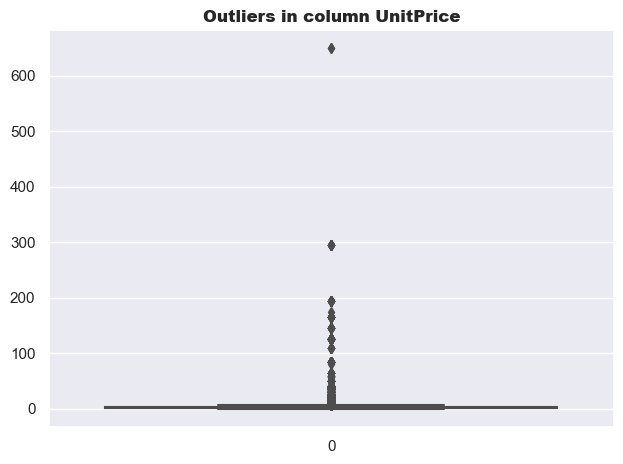

In [28]:
### Unit Price
sns.boxplot(sold_order["UnitPrice"],color="grey")
plt.title("Outliers in column UnitPrice",fontweight="black",size=12)
plt.tight_layout()
plt.show()

#### The unit Price seems to have outliners but it's ok to have them, as the price can vary from product to product.

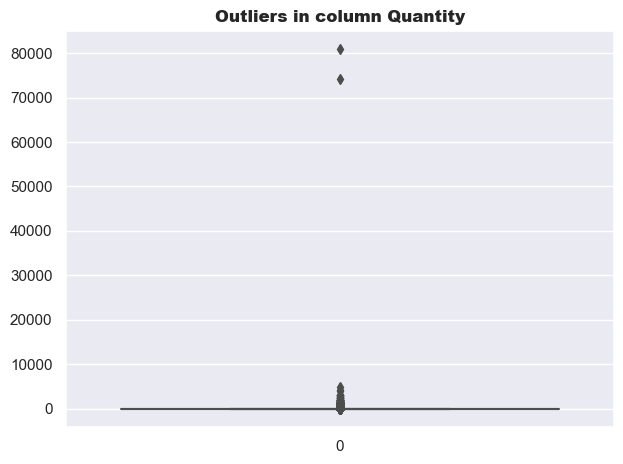

In [29]:
## Quantity
sns.boxplot(sold_order["Quantity"],color="grey")
plt.title("Outliers in column Quantity",fontweight="black",size=12)
plt.tight_layout()
plt.show()

#### The Quantity column exhibits two orders exceeding 70,000 units, significantly surpassing the mean Quantity value of 9.55225, indicating potential outliers.

In [30]:
## Dropping rows with values greater then 70000
sold_order = sold_order[sold_order['Quantity'] < 70000].copy()

In [31]:
## Sorting the dataset according to customerID and Invoice Date
sold_order.sort_values(by=['CustomerID', 'InvoiceDate'], inplace=True)

In [32]:
## Creating new column Purchase_date
sold_order['Purchase_date'] = sold_order['InvoiceDate'].dt.date
sold_order['Purchase_date'] = pd.to_datetime(sold_order['Purchase_date'])

In [33]:
## Creating new column Purchase_day
sold_order['Purchase_day'] = sold_order['InvoiceDate'].dt.dayofweek

In [34]:
## Creating new column Month-Year
sold_order['Purchase_Month_Year'] = sold_order['InvoiceDate'].dt.strftime('%Y-%m')

In [35]:
## Creating Hour Column
sold_order['Hour'] = sold_order['InvoiceDate'].dt.hour

In [36]:
### We will consider only those customers who are from UK.
sold_order = sold_order[sold_order['Country']  == 'United Kingdom']

In [37]:
sold_order.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Purchase_date,Purchase_day,Purchase_Month_Year,Hour
7146,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2010-12-05 15:38:00,2.55,12747.0,United Kingdom,2010-12-05,6,2010-12,15
7147,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2010-12-05 15:38:00,2.55,12747.0,United Kingdom,2010-12-05,6,2010-12,15
7148,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-05 15:38:00,1.69,12747.0,United Kingdom,2010-12-05,6,2010-12,15
7149,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,2010-12-05 15:38:00,1.65,12747.0,United Kingdom,2010-12-05,6,2010-12,15
7150,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747.0,United Kingdom,2010-12-05,6,2010-12,15


## Feature Engineering

In [38]:
### Creating a new column SalePrice
sold_order['Order_Amount'] = sold_order['Quantity'] * sold_order['UnitPrice']
can_order['Order_Amount'] = can_order['Quantity'] * can_order['UnitPrice']

## Descriptive statistical analysis of data

In [39]:
sold_order.describe()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Purchase_date,Purchase_day,Hour,Order_Amount
count,348870.000000,348870.000000,348870,348870.000000,348870.000000,348870,348870.000000,348870.000000,348870.000000
mean,560645.712830,11.692327,2011-07-11 03:30:29.865852928,2.864365,15548.450924,2011-07-10 14:12:00.061914368,2.634190,12.803377,20.056761
min,536365.000000,1.000000,2010-12-01 08:26:00,0.040000,12747.000000,2010-12-01 00:00:00,0.000000,6.000000,0.060000
25%,549243.000000,2.000000,2011-04-07 11:47:00,1.250000,14191.000000,2011-04-07 00:00:00,1.000000,11.000000,4.200000
50%,561889.000000,4.000000,2011-07-31 13:37:00,1.950000,15518.000000,2011-07-31 00:00:00,2.000000,13.000000,10.200000
75%,572281.000000,12.000000,2011-10-23 11:10:00,3.750000,16931.000000,2011-10-23 00:00:00,4.000000,14.000000,17.850000
max,581586.000000,4800.000000,2011-12-09 12:49:00,649.500000,18287.000000,2011-12-09 00:00:00,6.000000,20.000000,38970.000000
std,13148.335031,42.150681,NaN,4.341408,1594.294371,NaN,1.951579,2.246190,96.200118


In [40]:
sold_order.describe(include = 'object')

,StockCode,Description,Country,Purchase_Month_Year
count,348870,348870,348870,348870
unique,3638,3837,1,13
top,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,2011-11
freq,1936,1929,348870,57414


## RFM features
#### R(Recency) represents how recently a customer made a purchase
#### F(Frequency) represents the frequency of purchase
#### M(Monetary) represents the total amount of money a customer has spent over a certain period

In [41]:
## Recency
data = sold_order.groupby('CustomerID')['Purchase_date'].max().reset_index()
## we will use the max date of the dataset as a base.
max_date = sold_order['Purchase_date'].max()
max_date = pd.to_datetime(max_date)
data['Recency'] = (max_date - data['Purchase_date']).dt.days
data.drop(columns=['Purchase_date'], inplace=True)

In [42]:
## purchase Frequency
Purc_freq = sold_order.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
data = pd.merge(data, Purc_freq, on='CustomerID')

In [43]:
## M(Monetary) 
total_spend = sold_order.groupby('CustomerID')['Order_Amount'].sum().reset_index()
data = pd.merge(data, total_spend, on='CustomerID')
data.rename(columns={'Order_Amount': 'Monetary'}, inplace=True)

In [44]:
## Average order value
avg_order_value = (sold_order.groupby('CustomerID')['Order_Amount'].sum()/sold_order.groupby('CustomerID')['InvoiceNo'].nunique()).reset_index()
avg_order_value.columns = ['CustomerID', 'Avg_Order_Value']
data = pd.merge(data, avg_order_value, on='CustomerID')

In [45]:
## Total purchase quantity
Purc_quan = sold_order.groupby('CustomerID')['Quantity'].sum().reset_index()
data = pd.merge(data, Purc_quan, on='CustomerID')
data.rename(columns={'InvoiceNo': 'Frequency', 'Quantity': 'Total_Purc_quan'}, inplace=True)

In [46]:
## Customer spending behaviour.
monthly_spending = sold_order.groupby(['CustomerID', 'Purchase_Month_Year'])['Order_Amount'].sum().reset_index()
average_monthly_spending = monthly_spending.groupby('CustomerID')['Order_Amount'].mean().reset_index()
average_monthly_spending.columns = ['CustomerID', 'Avg_Monthly_Spending']
data = pd.merge(data, average_monthly_spending, on='CustomerID', how='left')

In [47]:
### Has customer purchased more then once
data['Reg/Not_Reg'] = data['Frequency'].apply(lambda x: 1 if x > 1 else 0)

In [48]:
## Has the customer churned
churn_threshold = 90 ## Considering the customer haven't shopped since more than 3 months
data['Has_Churned'] = data['Recency'].apply(lambda x: 1 if x > churn_threshold else 0)

In [49]:
## Customer cancellation behaviour.
can_freq = can_order.groupby('CustomerID')['InvoiceDate'].nunique().reset_index()
data = pd.merge(data, can_freq, on='CustomerID', how='left')
data.rename(columns={'InvoiceDate': 'Can_freq'}, inplace=True)
data['Can_freq'] = data['Can_freq'].fillna(0)
## Has customers ever cancelled any order
data['Has_ever_Cancelled'] = data['Can_freq'].apply(lambda x: 1 if x > 0 else 0)

## Feature engineering part 2

In [50]:
## Cancellation rate
data['Can_rate'] = data['Can_freq'] / (data['Can_freq'] + data['Frequency'])

In [51]:
data.head()

,CustomerID,Recency,Frequency,Monetary,Avg_Order_Value,Total_Purc_quan,Avg_Monthly_Spending,Reg/Not_Reg,Has_Churned,Can_freq,Has_ever_Cancelled,Can_rate
0,12747.0,2,11,4196.01,381.455455,1275,466.223333,1,0,0.0,0,0.000000
1,12748.0,0,206,31650.78,153.644563,25051,2434.675385,1,0,11.0,1,0.050691
2,12749.0,3,5,4040.88,808.176000,1470,1010.220000,1,0,3.0,1,0.375000
3,12820.0,3,4,942.34,235.585000,722,235.585000,1,0,0.0,0,0.000000
4,12821.0,214,1,92.72,92.720000,70,92.720000,0,1,0.0,0,0.000000


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915 entries, 0 to 3914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CustomerID            3915 non-null   float64
 1   Recency               3915 non-null   int64  
 2   Frequency             3915 non-null   int64  
 3   Monetary              3915 non-null   float64
 4   Avg_Order_Value       3915 non-null   float64
 5   Total_Purc_quan       3915 non-null   int64  
 6   Avg_Monthly_Spending  3915 non-null   float64
 7   Reg/Not_Reg           3915 non-null   int64  
 8   Has_Churned           3915 non-null   int64  
 9   Can_freq              3915 non-null   float64
 10  Has_ever_Cancelled    3915 non-null   int64  
 11  Can_rate              3915 non-null   float64
dtypes: float64(6), int64(6)
memory usage: 367.2 KB


In [53]:
data.describe()

,CustomerID,Recency,Frequency,Monetary,Avg_Order_Value,Total_Purc_quan,Avg_Monthly_Spending,Reg/Not_Reg,Has_Churned,Can_freq,Has_ever_Cancelled,Can_rate
count,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000,3915.000000
mean,15561.868455,91.879693,4.234227,1787.280235,350.381270,1041.916220,454.193846,0.654406,0.333589,0.758110,0.345083,0.099569
std,1576.217913,99.666473,7.155978,6834.630348,443.062027,3304.108116,1005.821744,0.475622,0.471555,1.867338,0.475456,0.161168
min,12747.000000,0.000000,1.000000,2.900000,2.900000,1.000000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14208.500000,17.000000,1.000000,296.670000,173.733750,153.000000,189.845000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15568.000000,50.000000,2.000000,643.760000,279.129091,365.000000,314.450000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,16913.500000,143.000000,5.000000,1563.780000,407.381026,944.500000,492.256500,1.000000,1.000000,1.000000,1.000000,0.200000
max,18287.000000,373.000000,206.000000,259657.300000,14844.766667,69973.000000,39916.500000,1.000000,1.000000,45.000000,1.000000,0.750000


## Data Preprocessing 2

In [54]:
## Checking for outliners
from sklearn.ensemble import IsolationForest
features = data[['Recency', 'Frequency', 'Monetary', 'Total_Purc_quan','Avg_Order_Value', 'Avg_Monthly_Spending']]
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['outlier'] = iso_forest.fit_predict(features)
data['outlier'] = data['outlier'].map({1: 0, -1: 1})
outliers = data[data['outlier'] == 1]
outliers

,CustomerID,Recency,Frequency,Monetary,Avg_Order_Value,Total_Purc_quan,Avg_Monthly_Spending,Reg/Not_Reg,Has_Churned,Can_freq,Has_ever_Cancelled,Can_rate,outlier
1,12748.0,0,206,31650.78,153.644563,25051,2434.675385,1,0,11.0,1,0.050691,1
12,12830.0,37,6,6814.64,1135.773333,9848,1703.660000,1,0,0.0,0,0.000000,1
59,12901.0,8,28,17654.54,630.519286,23075,1765.454000,1,0,6.0,1,0.176471,1
73,12921.0,9,37,16587.09,448.299730,9526,1507.917273,1,0,13.0,1,0.260000,1
81,12931.0,21,15,42055.96,2803.730667,28004,5256.995000,1,0,4.0,1,0.210526,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,18092.0,2,11,9068.26,824.387273,4252,1133.532500,1,0,1.0,1,0.083333,1
3778,18102.0,0,60,259657.30,4327.621667,64124,21638.108333,1,0,0.0,0,0.000000,1
3783,18109.0,1,26,8004.92,307.881538,4230,615.763077,1,0,5.0,1,0.161290,1
3805,18139.0,17,6,8438.34,1406.390000,5557,8438.340000,1,0,0.0,0,0.000000,1


In [55]:
## Extracting data without outliner
inliner_data = data[data['outlier'] == 0].copy()
## dropping column outlier
inliner_data.drop(columns=['outlier'], inplace = True)

### Checking Multicollinearity using correlation matrix and Variance Inflation Factor (VIF)

<Axes: >

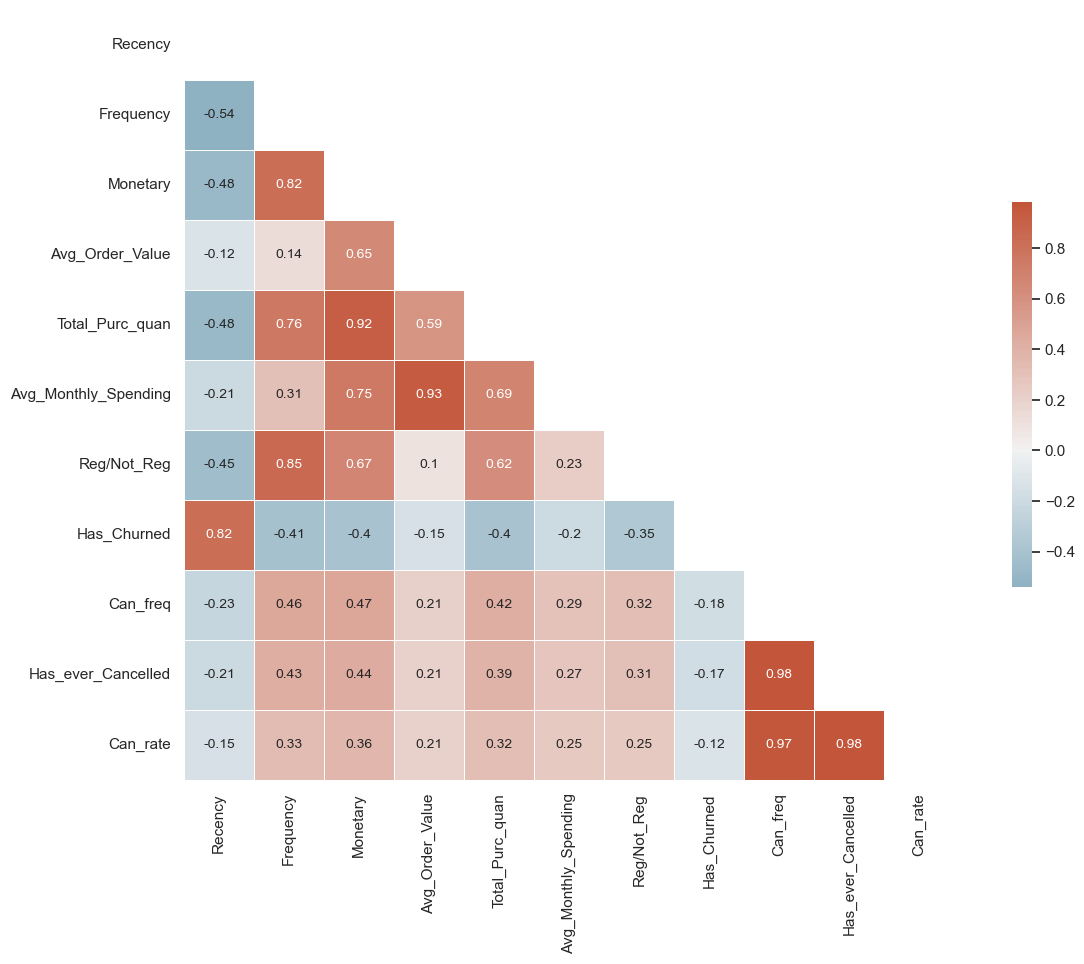

In [56]:
## Correlation
corr_mat = inliner_data.drop(columns=['CustomerID'])
sns.set_theme(style="white")
corr = corr_mat.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":10})

#### Removed column Can_rate because of multicolinearity.

In [57]:
final_data = inliner_data[['CustomerID','Recency', 'Frequency', 'Monetary','Total_Purc_quan','Avg_Monthly_Spending',
                           'Avg_Order_Value','Reg/Not_Reg', 'Has_Churned','Can_freq',
       'Has_ever_Cancelled', ]].copy()

In [58]:
final_data.describe()

,CustomerID,Recency,Frequency,Monetary,Total_Purc_quan,Avg_Monthly_Spending,Avg_Order_Value,Reg/Not_Reg,Has_Churned,Can_freq,Has_ever_Cancelled
count,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000,3719.000000
mean,15570.163754,93.201398,3.435601,1070.511315,647.702070,351.165904,304.108497,0.644797,0.340145,0.598279,0.324550
std,1573.841324,99.219434,3.409489,1253.182653,808.475203,230.585611,188.759572,0.478639,0.473821,1.224397,0.468269
min,12747.000000,0.000000,1.000000,2.900000,1.000000,2.900000,2.900000,0.000000,0.000000,0.000000,0.000000
25%,14221.500000,18.000000,1.000000,285.055000,146.500000,183.500000,168.713750,0.000000,0.000000,0.000000,0.000000
50%,15574.000000,52.000000,2.000000,600.190000,335.000000,305.660000,266.650000,1.000000,0.000000,0.000000,0.000000
75%,16922.000000,147.000000,4.000000,1371.475000,820.000000,449.772500,385.037500,1.000000,1.000000,1.000000,1.000000
max,18287.000000,373.000000,27.000000,9585.910000,9322.000000,1873.200000,1393.060000,1.000000,1.000000,18.000000,1.000000


## Feature scaling

#### Since column CustomerID is an identifier, while columns such as Has_Churned and  Has_ever_Cancelled  are categorical. We wouldn't scale them.

In [59]:
## Standardzing the data
scaled_data = final_data.copy()
feature_to_scale = ['Recency', 'Frequency', 'Monetary','Total_Purc_quan', 'Avg_Order_Value',
                     'Can_freq', 'Avg_Monthly_Spending']
scaler = StandardScaler()
scaled_data[feature_to_scale] = scaler.fit_transform(scaled_data[feature_to_scale])
scaled_data.head()

,CustomerID,Recency,Frequency,Monetary,Total_Purc_quan,Avg_Monthly_Spending,Avg_Order_Value,Reg/Not_Reg,Has_Churned,Can_freq,Has_ever_Cancelled
0,12747.0,-0.919312,2.218929,2.494384,0.776007,0.499046,0.409820,1,0,-0.488697,0
2,12749.0,-0.909232,0.458898,2.370579,1.017234,2.858560,2.670780,1,0,1.961818,1
3,12820.0,-0.909232,0.165560,-0.102290,0.091911,-0.501317,-0.363069,1,0,-0.488697,0
4,12821.0,1.217653,-0.714456,-0.780351,-0.714654,-1.120975,-1.120033,0,1,-0.488697,0
5,12822.0,-0.233871,-0.421117,-0.097071,-0.120864,2.592506,0.902494,1,0,0.328141,1


### Dimension reduction using PCA

In [60]:
scaled_data.set_index('CustomerID', inplace=True)

In [61]:
pca = PCA().fit(scaled_data[feature_to_scale])

In [62]:
pca.explained_variance_ratio_

array([0.53499517, 0.21552094, 0.11750271, 0.08164635, 0.02875695,
       0.01208648, 0.0094914 ])

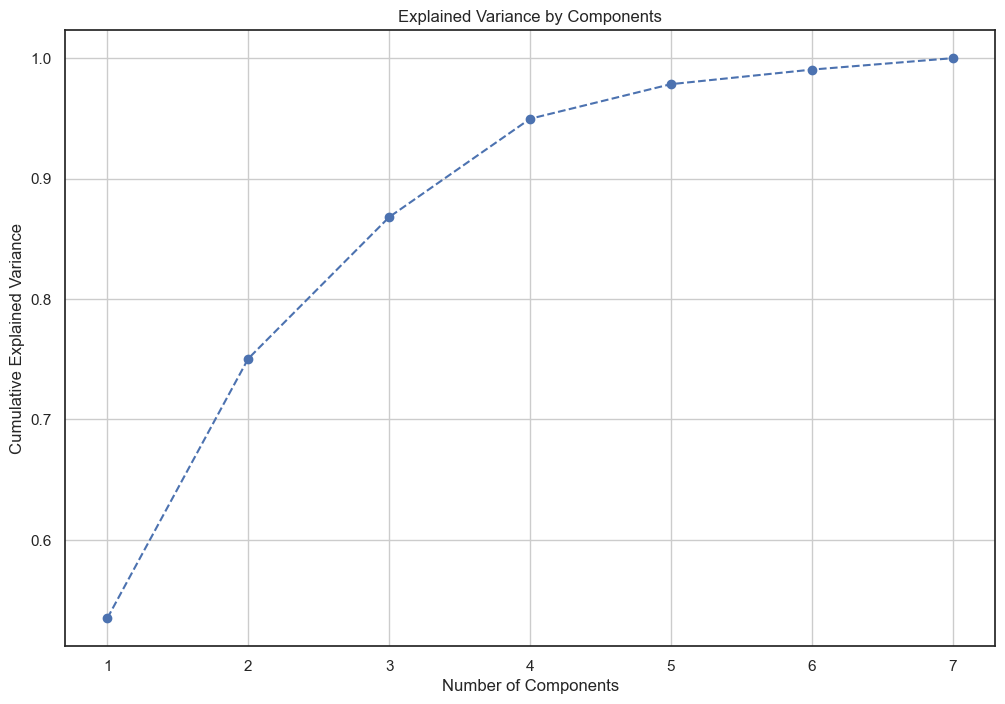

In [63]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), 
         marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1, 1))
plt.grid(True)
plt.show()

#### According to the graph more then 80% of the data is explained by 4 components. So, we will use 4 components for the PCA

In [64]:
pca = PCA(n_components = 3)
pca_data = pca.fit_transform(scaled_data)

In [65]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = scaled_data.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp.T

,Component 1,Component 2,Component 3
Recency,-0.257807,-0.222352,0.797566
Frequency,0.400937,0.381431,0.105653
Monetary,0.478901,0.047911,0.107455
Total_Purc_quan,0.448293,0.059947,0.077763
Avg_Monthly_Spending,0.353227,-0.541977,-0.027628
Avg_Order_Value,0.279615,-0.644605,-0.052349
Reg/Not_Reg,0.123737,0.112796,-0.100906
Has_Churned,-0.109005,-0.086034,0.342471
Can_freq,0.312752,0.253224,0.430798
Has_ever_Cancelled,0.120462,0.075361,0.136284


([<matplotlib.axis.YTick at 0x237e4097590>,
 [Text(0, 0, 'Component 1'),
  Text(0, 1, 'Component 2'),
  Text(0, 2, 'Component 3')])

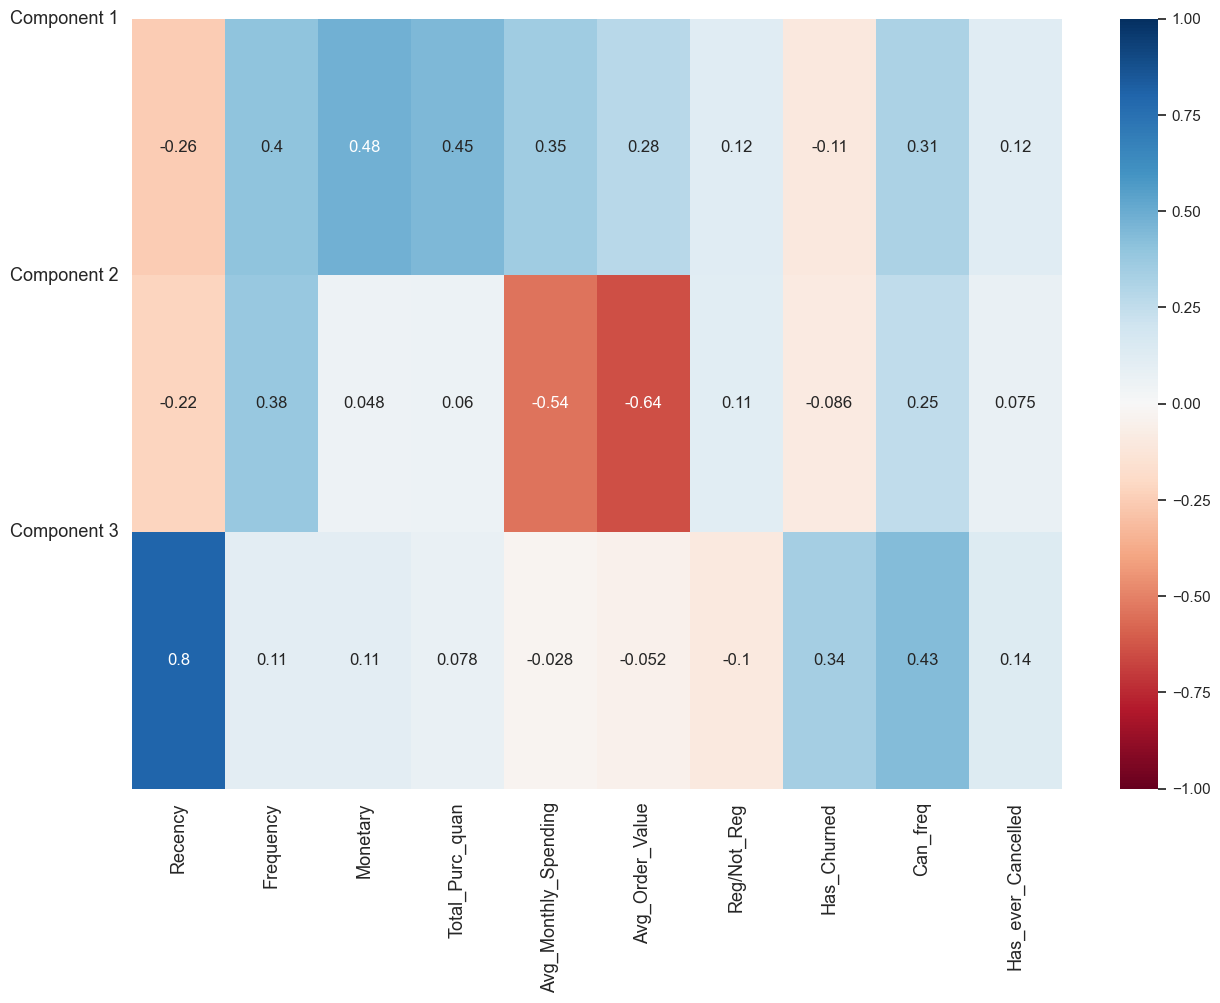

In [66]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_pca_comp, vmin = -1, vmax = 1, cmap = 'RdBu', annot = True)
plt.xticks(fontsize = 13)
plt.yticks([0,1,2], ['Component 1', 'Component 2', 'Component 3'],
           rotation = 0, fontsize = 13)

## Determining the optimal number of clusters.

### Elbow methods.

In [67]:
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',n_init=10, random_state = 42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

  File "C:\Users\him10\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


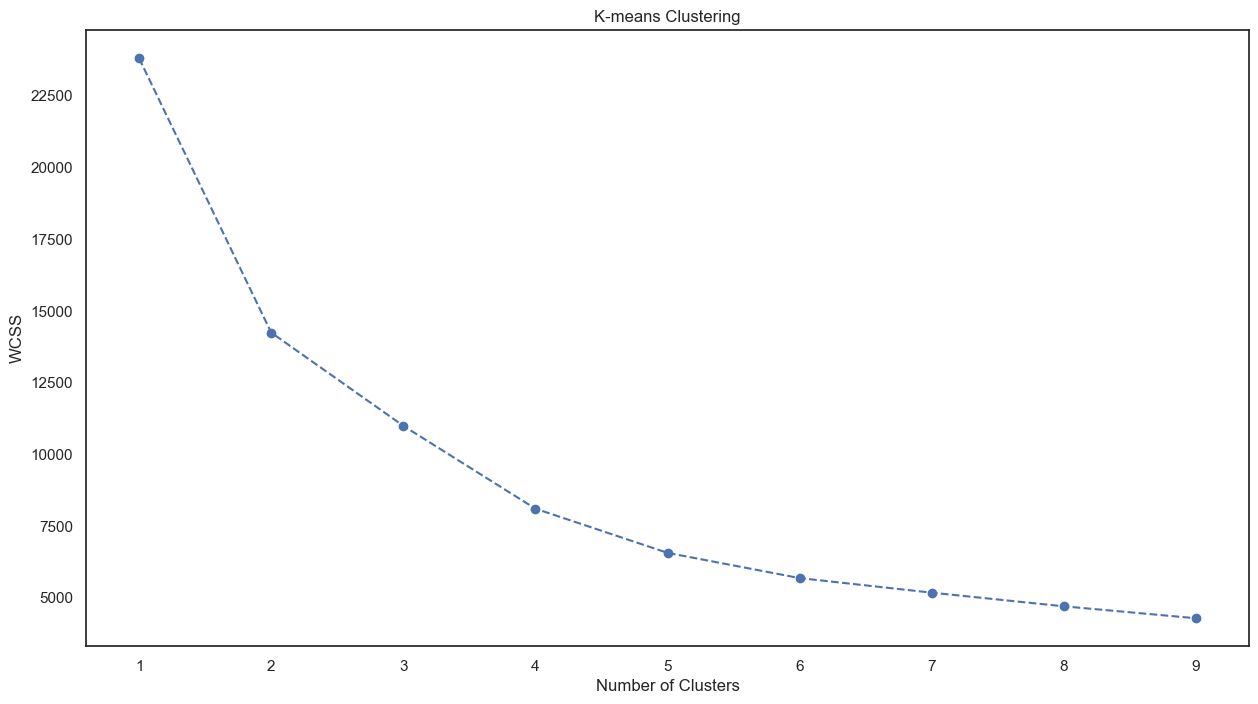

In [68]:
plt.figure(figsize = (15,8))
plt.plot(range(1, 10), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

#### The elbow methods also suggest 4 clusters. So, we will initialize k means with 4 clusters.

In [69]:
## Clustering using Kmeans++
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++',n_init=10, random_state = 42)
kmeans_pca.fit(pca_data)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [70]:
### Final data with pca components and cluster labels
final_cluster_data = pd.concat([final_data.reset_index(drop = True), pd.DataFrame(pca_data)], axis = 1)
final_cluster_data.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
final_cluster_data['Cluster'] = kmeans_pca.labels_

In [71]:
final_cluster_data.head()  

,CustomerID,Recency,Frequency,Monetary,Total_Purc_quan,Avg_Monthly_Spending,Avg_Order_Value,Reg/Not_Reg,Has_Churned,Can_freq,Has_ever_Cancelled,Component 1,Component 2,Component 3,Cluster
0,12747.0,2,11,4196.01,1275,466.223333,381.455455,1,0,0.0,0,2.849059,0.603287,-0.612730,1
1,12749.0,3,5,4040.88,1470,1010.220000,808.176000,1,0,3.0,1,4.542157,-2.102095,0.223227,3
2,12820.0,3,4,942.34,722,235.585000,235.585000,1,0,0.0,0,-0.096504,0.692788,-1.085762,0
3,12821.0,214,1,92.72,70,92.720000,92.720000,0,1,0.0,0,-2.347243,0.428320,0.882134,2
4,12822.0,70,2,948.88,550,948.880000,474.440000,1,0,1.0,1,1.223899,-1.904028,-0.288634,3


## EDA

In [89]:
eda_data = final_cluster_data.drop(columns=['CustomerID'])

In [93]:
df_segm_pca_kmeans_freq = eda_data.groupby(['Cluster']).mean()
df_segm_pca_kmeans_freq.T

Cluster,0,1,2,3
Recency,40.273140,22.512019,234.541237,67.875874
Frequency,2.990346,10.588942,1.444330,2.980769
Monetary,680.515423,3673.615577,307.790969,1671.438112
Total_Purc_quan,421.841567,2242.408654,173.335052,987.699301
Avg_Monthly_Spending,259.941220,531.674281,234.561316,698.476455
Avg_Order_Value,233.961745,371.166760,223.463551,608.055681
Reg/Not_Reg,0.725724,1.000000,0.290722,0.737762
Has_Churned,0.081204,0.038462,1.000000,0.237762
Can_freq,0.340716,2.646635,0.242268,0.505245
Has_ever_Cancelled,0.255537,0.870192,0.189691,0.368881


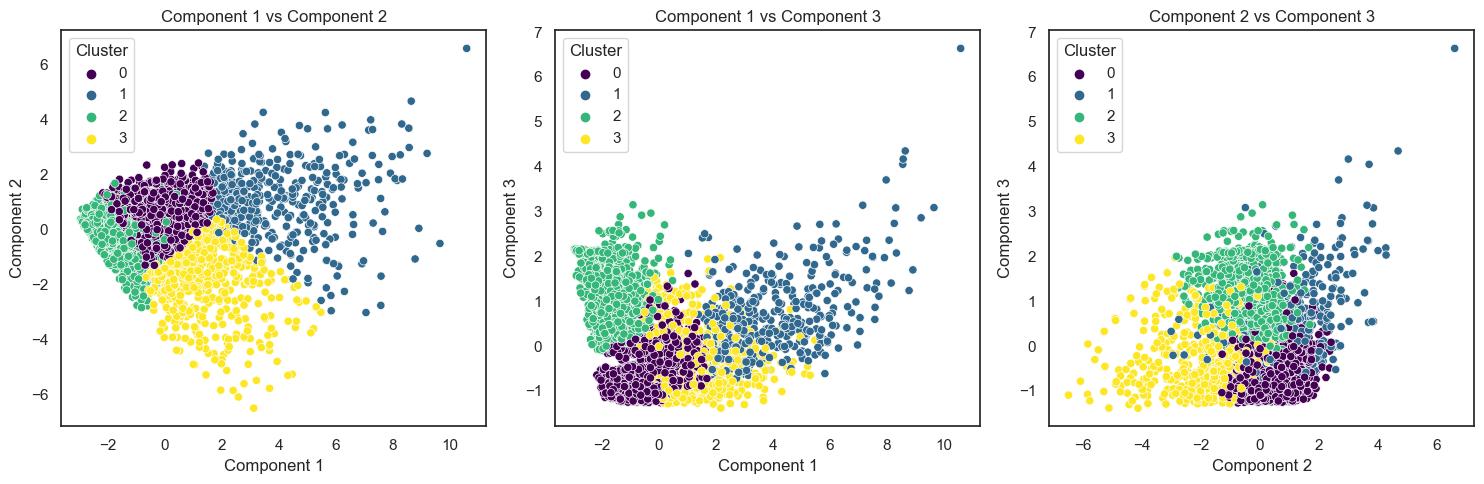

In [73]:
component_pairs = [('Component 1', 'Component 2'), ('Component 1', 'Component 3'), 
                   ('Component 2', 'Component 3')]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, (x_col, y_col) in enumerate(component_pairs):
    ax = axes[i]
    sns.scatterplot(data=final_cluster_data, x=x_col, y=y_col, hue='Cluster', palette='viridis', ax=ax)
    ax.set_title(f'{x_col} vs {y_col}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)

plt.tight_layout()
plt.show()


### Spending habits across different clusters.
### Insights: - Identify high-value customers and potential VIP segments.

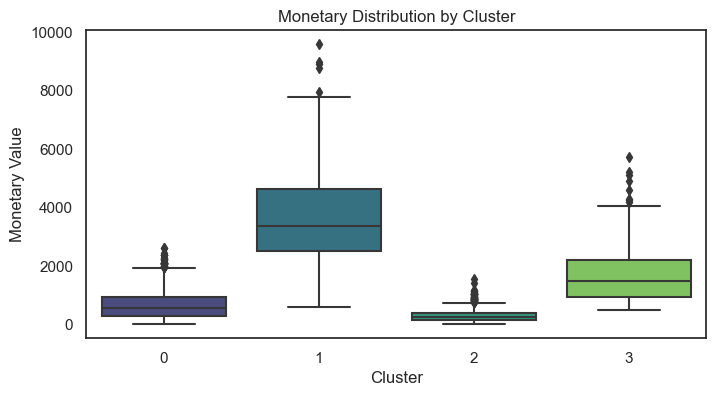

In [74]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=final_cluster_data, x='Cluster', y='Monetary', palette='viridis')
plt.title('Monetary Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary Value')
plt.show()

### Recency of purchases across clusters.
### Insight: Identify customers who have recently purchased and those who might be at risk of churning.

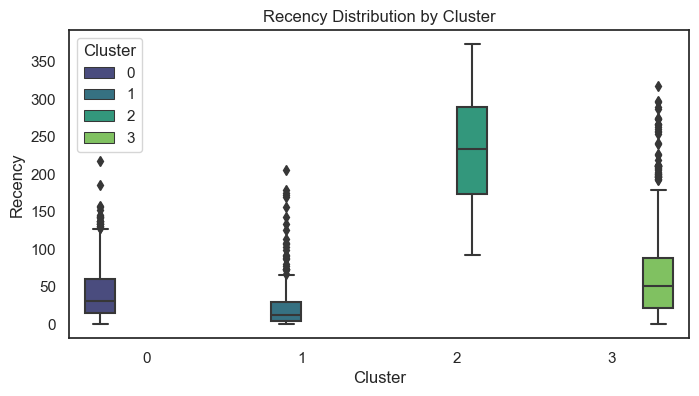

In [75]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=final_cluster_data, x='Cluster', y='Recency',hue='Cluster', palette='viridis')
plt.title('Recency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

### Relationship between how often and how recently customers purchase.
### Insight: Differentiate between frequent buyers, loyal customers, and those who may need re-engagement strategies.

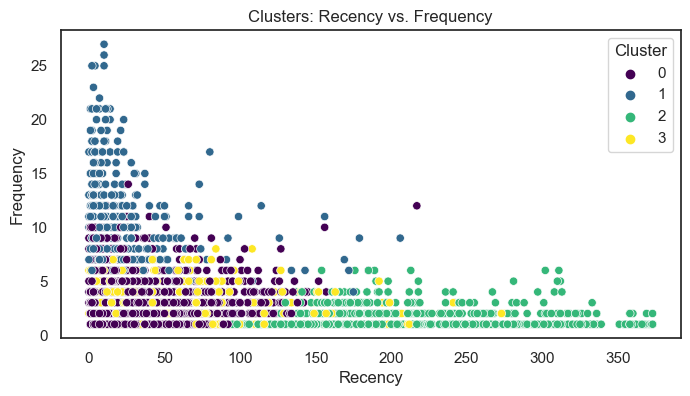

In [76]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=final_cluster_data, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('Clusters: Recency vs. Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

### Number of customers in each cluster.
### Insight: Understand the size of each customer segment for resource allocation.

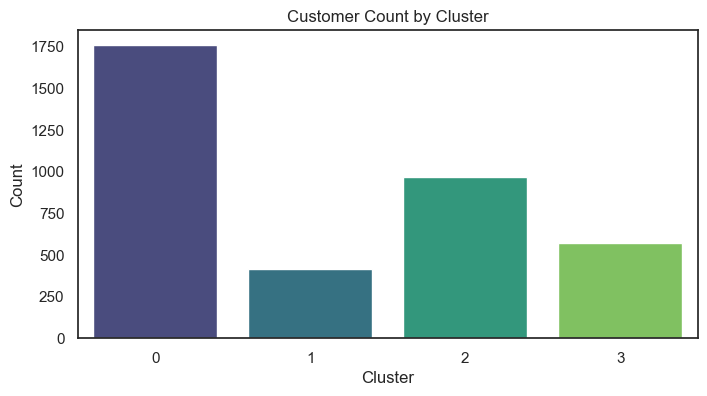

In [77]:
plt.figure(figsize=(8, 4))
sns.countplot(data=final_cluster_data, x='Cluster', palette='viridis')
plt.title('Customer Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### Distribution of average order values across clusters.
### Insight: Determine which clusters have higher average order values and may represent more valuable customers.

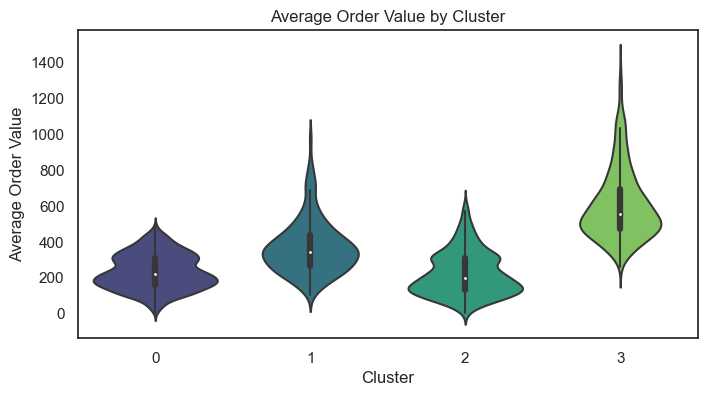

In [78]:
plt.figure(figsize=(8, 4))
sns.violinplot(data=final_cluster_data, x='Cluster', y='Avg_Order_Value', palette='viridis')
plt.title('Average Order Value by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Order Value')
plt.show()

### Clusters in a reduced dimensional space.
### Insight: Understand the separation and cohesion of clusters in the most informative components.

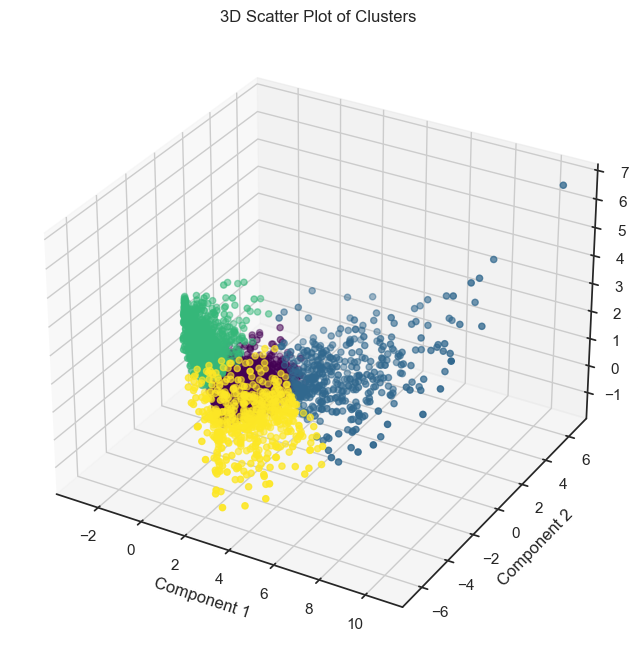

In [79]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_cluster_data['Component 1'], final_cluster_data['Component 2'], final_cluster_data['Component 3'], c=final_cluster_data['Cluster'], cmap='viridis')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title('3D Scatter Plot of Clusters')
plt.show()


### Spatial distribution and relationships between the clusters based on three key features: Recency, Frequency, and Monetary value.

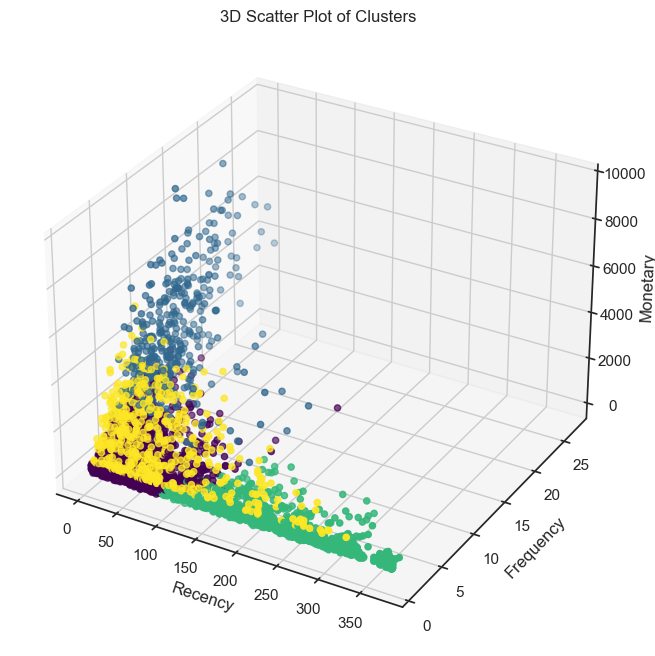

In [80]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_cluster_data['Recency'], final_cluster_data['Frequency'], final_cluster_data['Monetary'], c=final_cluster_data['Cluster'], cmap='viridis')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Scatter Plot of Clusters')
plt.show()

### Pairwise relationships between key features.
### Insight: Identify correlations and patterns that may inform targeted marketing or retention strategies.

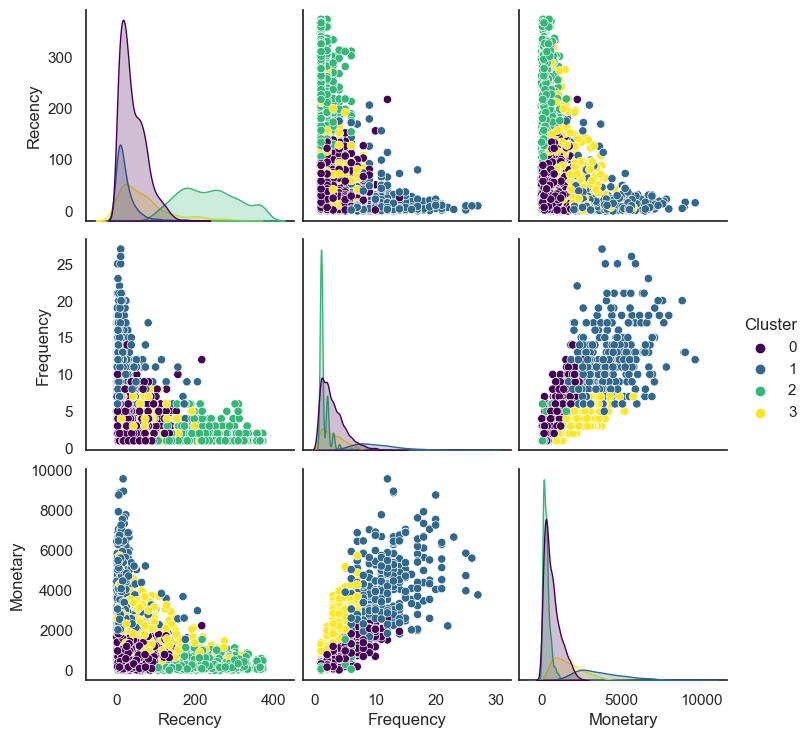

In [81]:
key_features = ['Recency', 'Frequency', 'Monetary']
sns.pairplot(final_cluster_data[key_features + ['Cluster']], hue='Cluster', diag_kind='kde', palette='viridis')
plt.show()